In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('hour_online.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Time    2625 non-null   object
 1   Users   2625 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 41.1+ KB


### Первоначально посмотрим как выглядит наш ряд


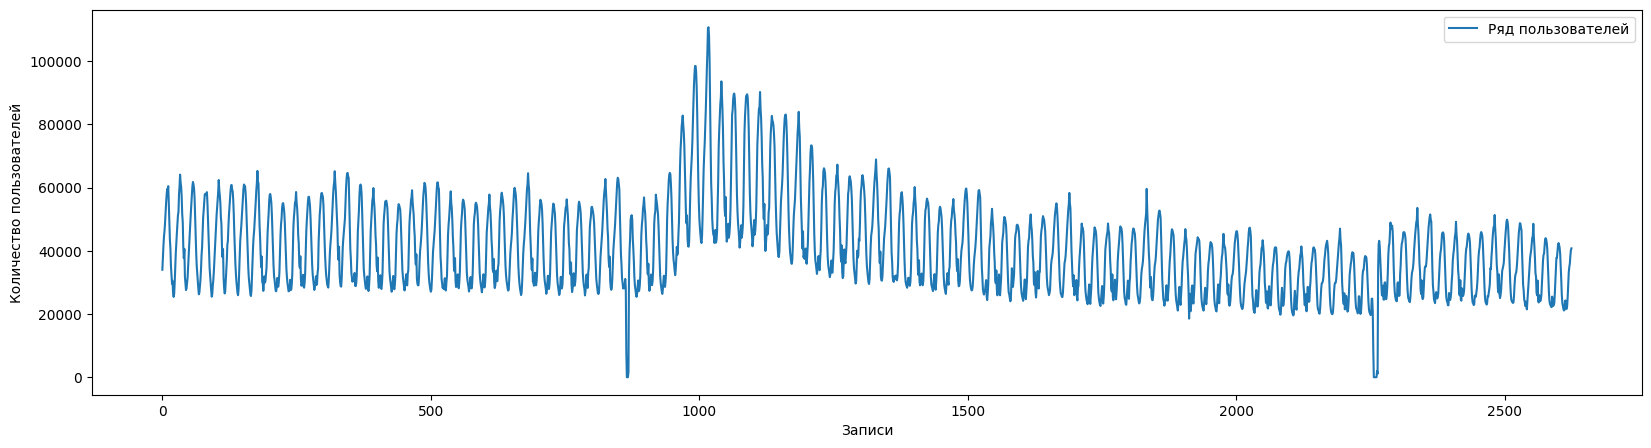

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df['Users'], label='Ряд пользователей')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

### Проверим наш ряд на стационарность.
 Если он является стационарным, то какие-то преобразования мы делать не будем

 Если он не стационарен, то будем прибегать к методам его преобразования, чтобы сделать его(или приблизить) к стационарному

 Исходя из графика выше можно сделать вывод, что он является нестационарным, но для убедительности мы его еще проверим на тесте Дики-Фуллера

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Users'], regression='c')  # Используем константу

print('DF(значение статистики):', result[0])
print('Критические значения:')

for key, value in result[4].items():
        if result[0] < value:
            print(f'При уровне значимости {key}({value}), нулевая гипотеза отвергается: ряд стационарен.')
        else:
            print(f'При уровне значимости {key}({value}), нулевая гипотеза не отвергается: ряд нестационарен.')

DF(значение статистики): -2.2453790321361367
Критические значения:
При уровне значимости 1%(-3.43286857268081), нулевая гипотеза не отвергается: ряд нестационарен.
При уровне значимости 5%(-2.8626527106640043), нулевая гипотеза не отвергается: ряд нестационарен.
При уровне значимости 10%(-2.567362335821588), нулевая гипотеза не отвергается: ряд нестационарен.


Результат теста подтверждает, что ряд нестационарен.
Поэтому мы будем наш ряд преобразовывать используя метод дифференцирования(вычисление разностей между последовательными значениями ряда)

In [ ]:
diff_series = df['Users'].diff().dropna()

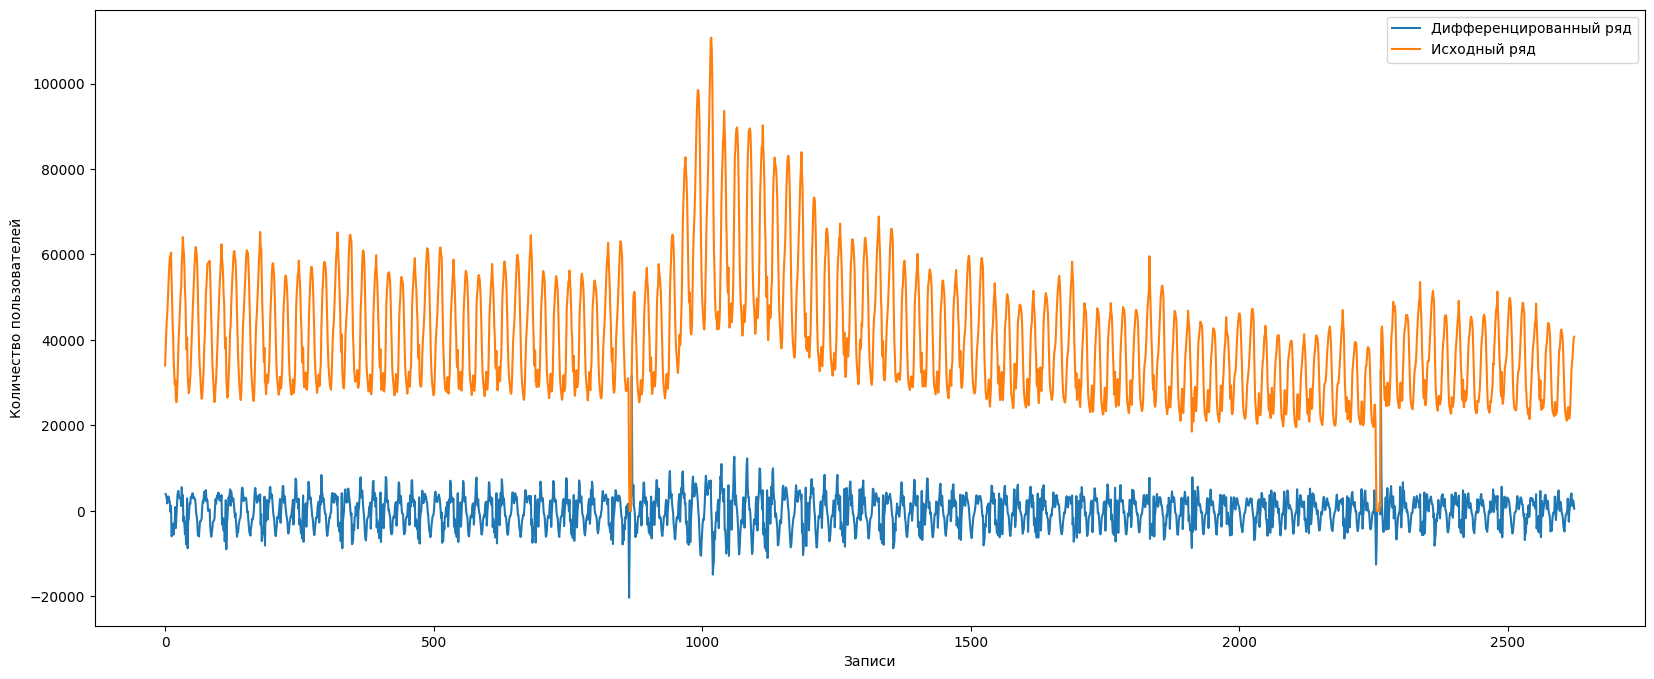

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(diff_series, label='Дифференцированный ряд')
plt.plot(df['Users'], label='Исходный ряд')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

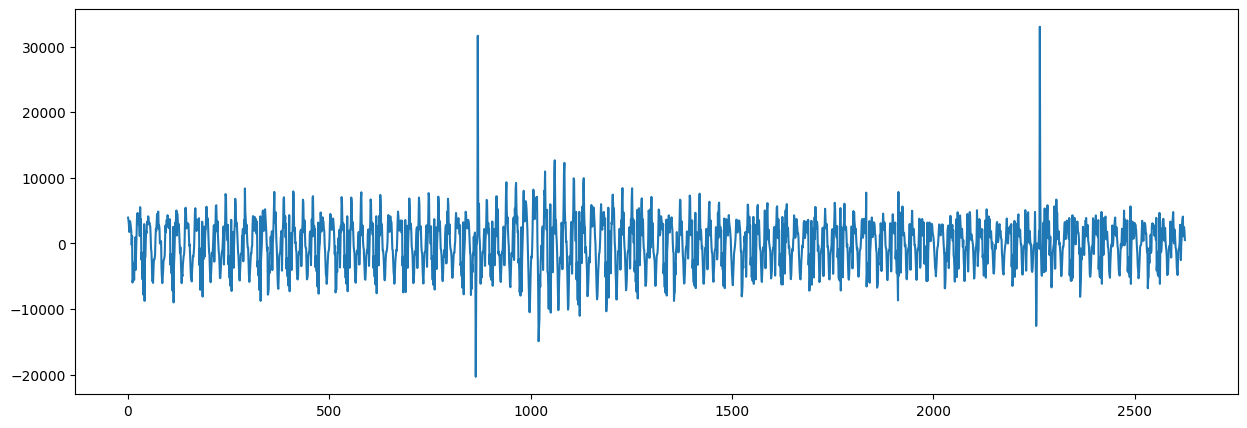

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(diff_series, label='Дифференцированный ряд')

По графику видно, что ряд изменился и стал стационарным, но присутствуют выбросы(шумы). Проверим его на тесте Дики-Фуллера

In [ ]:
result = adfuller(diff_series, regression='c')  # Используем константу

print('DF(значение статистики):', result[0])
print('Критические значения:')

for key, value in result[4].items():
        if result[0] < value:
            print(f'При уровне значимости {key}({value}), нулевая гипотеза отвергается: ряд стационарен.')
        else:
            print(f'При уровне значимости {key}({value}), нулевая гипотеза не отвергается: ряд нестационарен.')

DF(значение статистики): -11.095149190442571
Критические значения:
При уровне значимости 1%(-3.4328724587241686), нулевая гипотеза отвергается: ряд стационарен.
При уровне значимости 5%(-2.862654426799674), нулевая гипотеза отвергается: ряд стационарен.
При уровне значимости 10%(-2.567363249505311), нулевая гипотеза отвергается: ряд стационарен.


После того, как мы изменили наш ряд и проверили его на стационарность, пришло время поделить его на тестовый и обучающие. По условию задания мы будем делать следующим образом: до времени 4/10/17 0:00 у нас будет тренировочный сет, а после тестовый(валидационный). Ниже приведен код, в которм описано наше разделение

In [ ]:
index_train = df[df['Time'] == '4/10/17 0:00'].index[0]

train_series = diff_series[:index_train]
test_series = diff_series[index_train:]

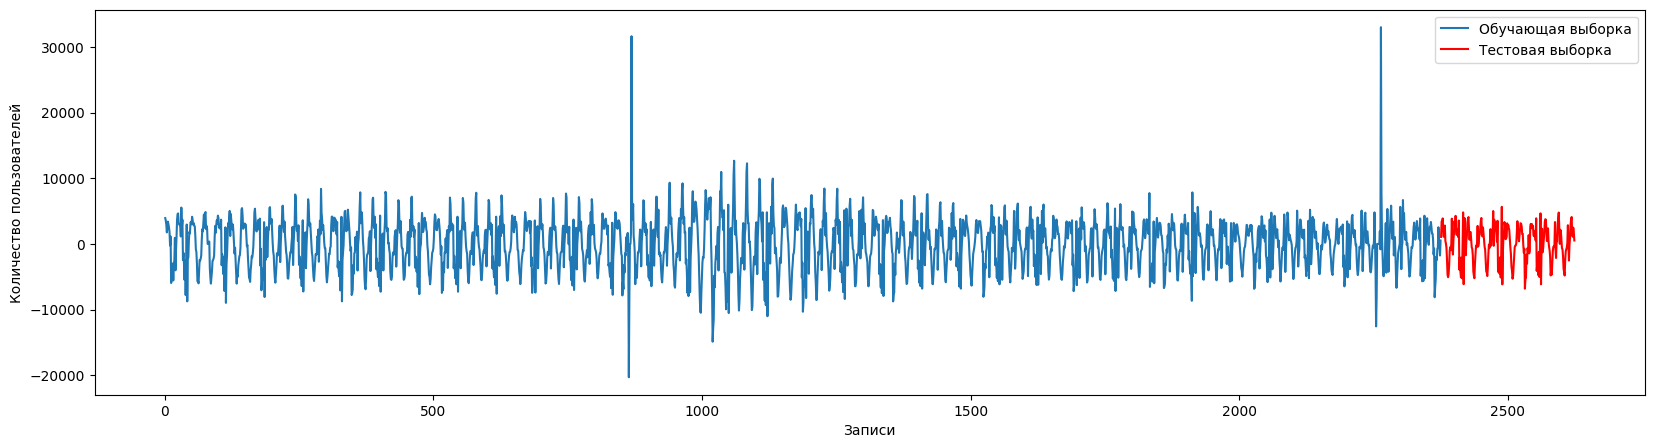

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(train_series, label='Обучающая выборка')
plt.plot(test_series, label='Тестовая выборка', color='red')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

### Модель ARIMA

Дальше мы использовали модель ARIMA, которая использует параметры p, d, q

ARIMA -> AR(p), I(d), MA(q)

p -> указывает, сколько прошлых значений включать в модель.

d -> обозначает порядок дифференцирования. Он указывает, сколько раз необходимо дифференцировать временной ряд, чтобы сделать его стационарным.

q -> обозначает порядок модели скользящего среднего. Он указывает, сколько прошлых ошибок (остатков) включать в модель.

Исходя из того, что мы уже дифференцировали наш ряд, то значение d мы приравниваем к 0, а другие пока поставим по нашему усмотрению и посмотрим, каким будет результат

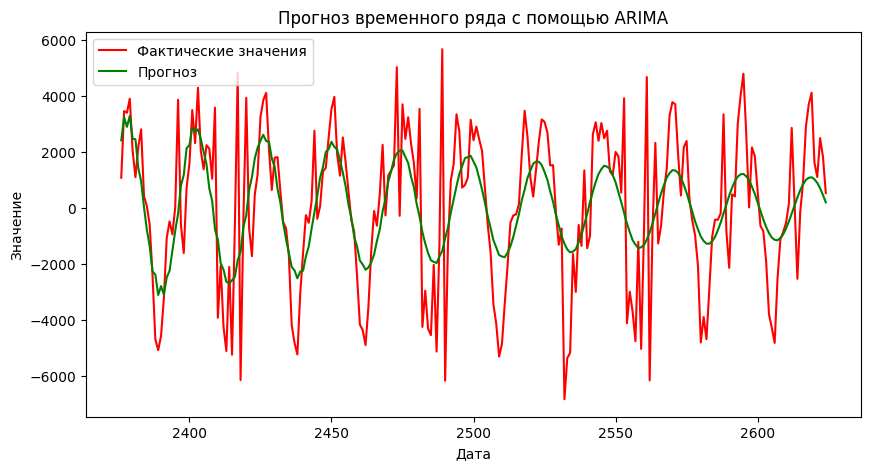

MAE: 1475.0688268677854


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error


# Создание и обучение модели ARIMA
model = ARIMA(train_series, order=(5, 0, 7)) #14, 0, 19
model_fit = model.fit()

# Прогнозирование на тестовой выборке
forecast = model_fit.forecast(steps=len(test_series))

# Визуализация прогнозов и фактических значений тестовой выборки
plt.figure(figsize=(10, 5))
plt.plot(test_series.index, test_series.values, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae = mean_absolute_error(test_series, forecast)
print(f'MAE: {mae}')


Найдем наилучшие значения p и q используя Optuna:

0 <= p <= 50

0 <= q <= 50

Количество итераций поставим 100


In [ ]:
import optuna
import time

def objective(trial):
    start_time = time.time()
    p = trial.suggest_int('p', 0, 50)
    d = 0
    q = trial.suggest_int('q', 0, 50)

    model = ARIMA(train_series, order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_series))

    error = mean_absolute_error(test_series, forecast)
    end_time = time.time()
    print(f'Время: {(end_time - start_time)/60:.2f} минут')
    return error


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
print("Best parameters:", best_params)


In [ ]:
best_model = ARIMA(train_series, order=(best_params['p'], 0, best_params['q']))
best_model_fit = best_model.fit()
best_forecast = best_model_fit.forecast(steps=len(test_series))

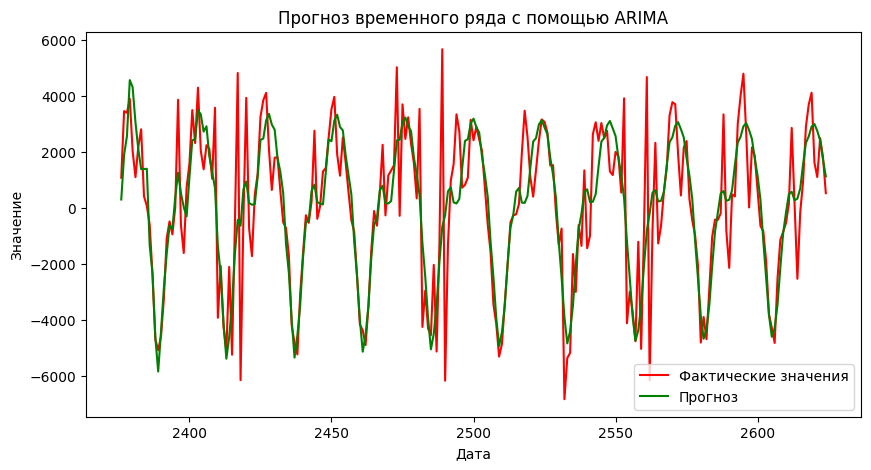

MAE: 1040.9879010389013


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_series.index, test_series.values, label='Фактические значения', color='red')
plt.plot(test_series.index, best_forecast.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae = mean_absolute_error(test_series, best_forecast)
print(f'MAE: {mae}')

Всего было 3 запуска и лучшими моделями были следующие:

1) p = 34, d = 0, q = 31

2) p = 35, d = 0, q = 7

3) p = 34, d = 0, q = 28

In [ ]:
model_1 = ARIMA(train_series, order=(34, 0, 31))
model_fit_1 = model_1.fit()
forecast_1 = model_fit_1.forecast(steps=len(test_series))

model_2 = ARIMA(train_series, order=(35, 0, 7))
model_fit_2 = model_2.fit()
forecast_2 = model_fit_2.forecast(steps=len(test_series))

model_3 = ARIMA(train_series, order=(34, 0, 28))
model_fit_3 = model_3.fit()
forecast_3 = model_fit_3.forecast(steps=len(test_series))


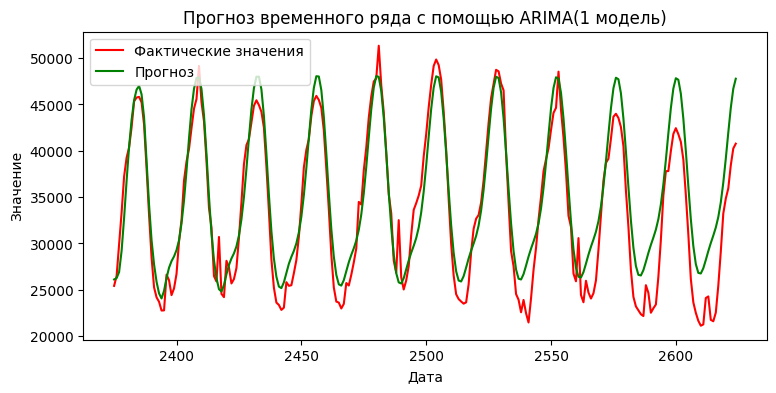

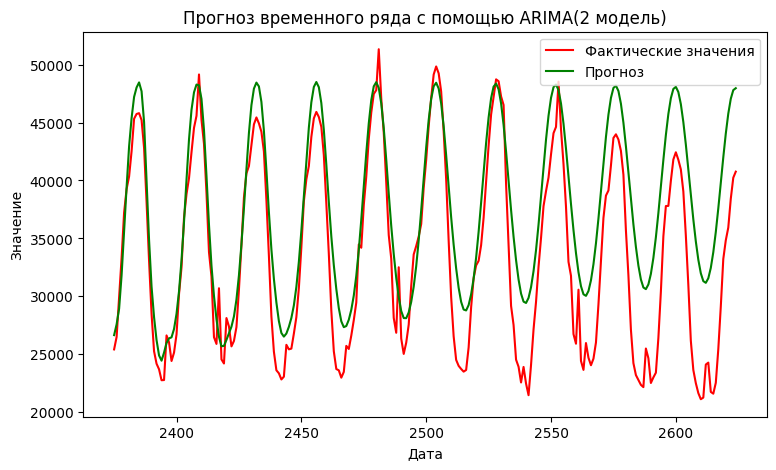

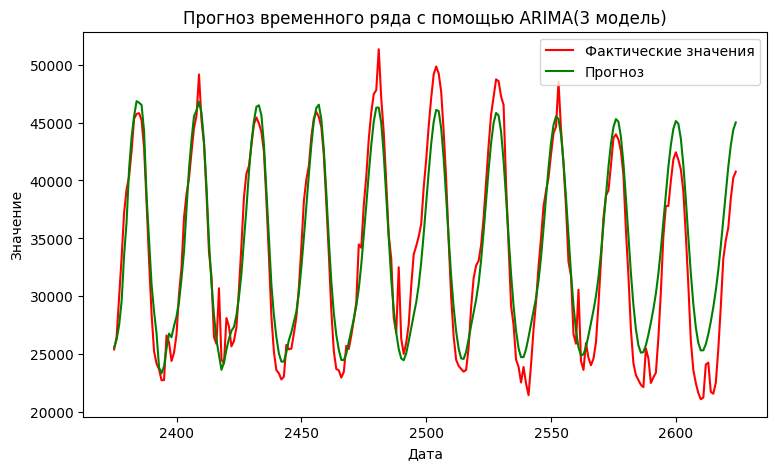

In [ ]:
plt.figure(figsize=(30, 4))
plt.subplot(1,3,1)
plt.plot(test_series.index, test_series.values, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast_1.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA(1 модель)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

plt.figure(figsize=(30, 5))
plt.subplot(1,3,2)
plt.plot(test_series.index, test_series.values, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast_2.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA(2 модель)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

plt.figure(figsize=(30, 5))
plt.subplot(1,3,3)
plt.plot(test_series.index, test_series.values, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast_3.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA(3 модель)')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()


In [ ]:
mae_1 = mean_absolute_error(test_series, forecast_1)
mae_2 = mean_absolute_error(test_series, forecast_2)
mae_3 = mean_absolute_error(test_series, forecast_3)

print(f'MAE:\n1 - {mae_1}\n2 - {mae_2}\n3 - {mae_3}')

MAE:
1 - 1040.9879010389013
2 - 1230.178659009583
3 - 1075.0439315015215


### Кросс-валидация
Всего у нас 4 месаца(почти), 110 дней:

1 месяц - 31

2 месяц - 28

3 месяц - 31

4 месяц - 20

У нас три будет запуска:

**Вариант 1**

1) 80 дней обучающее, а 10 тест

2) 80+10 дней обучающее, а 10 тест

3) 80 + 2*10 дней обучающее, а 10 тест

**Вариант 2**

Будет тоже самое, только обучающая выборка будет все три раза 80, а тест 10, т. е. часть в тренировочном будет отбрасываться и дополняться тестом на предыдущем запуске


In [ ]:
#Вариатн 1

index_train_main = df[df['Time'] == '3/20/17 0:00'].index[0] #80
index_test_first_10 = df[df['Time'] == '3/31/17 0:00'].index[0] # 10

train_series_1 = diff_series[:index_train_main]
test_series_1 = diff_series[index_train_main:index_test_first_10]

index_test_second_10 = df[df['Time'] == '4/10/17 0:00'].index[0]
train_series_2 = diff_series[:index_test_first_10]  # 80+10
test_series_2 = diff_series[index_test_first_10:index_test_second_10] #10

train_series_3 = diff_series[:index_test_second_10]  # 80+10+10
test_series_3 = diff_series[index_test_second_10:] #10

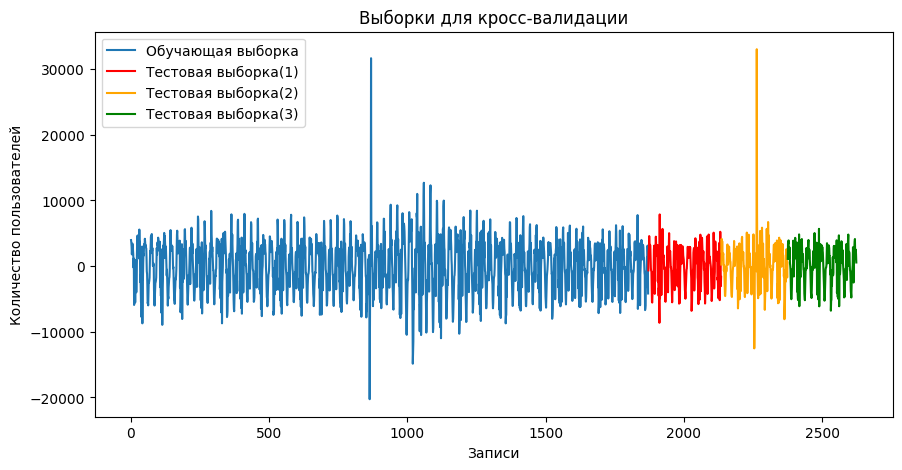

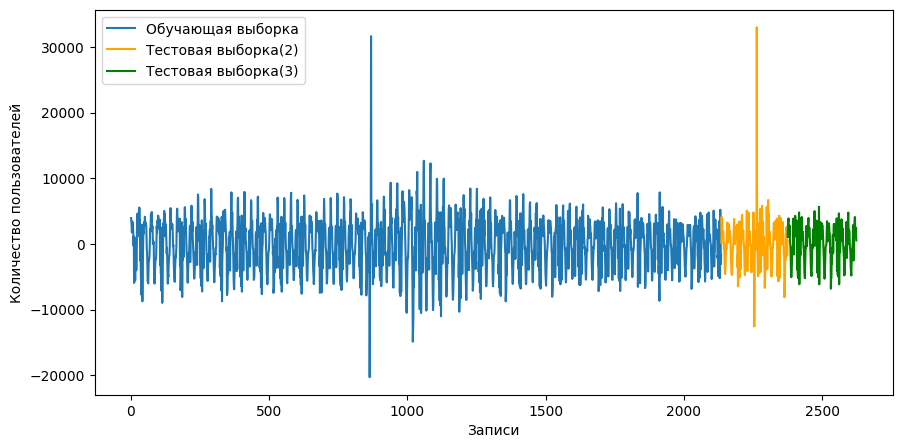

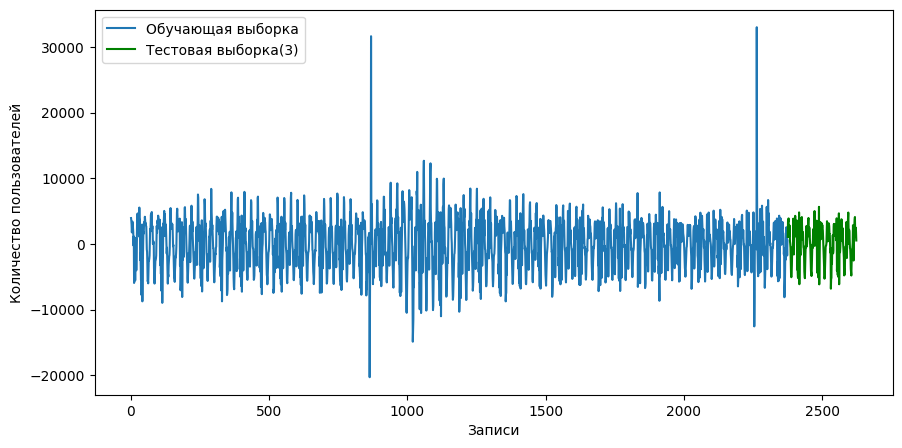

In [ ]:
plt.figure(figsize=(35, 5))
plt.subplot(1,3,1)
plt.plot(train_series_1, label='Обучающая выборка')
plt.plot(test_series_1, label='Тестовая выборка(1)', color='red')
plt.plot(test_series_2, label='Тестовая выборка(2)', color='orange')
plt.plot(test_series_3, label='Тестовая выборка(3)', color='green')
plt.title('Выборки для кросс-валидации')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

plt.figure(figsize=(35, 5))
plt.subplot(1,3,2)
plt.plot(train_series_2, label='Обучающая выборка')
plt.plot(test_series_2, label='Тестовая выборка(2)', color='orange')
plt.plot(test_series_3, label='Тестовая выборка(3)', color='green')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

plt.figure(figsize=(35, 5))
plt.subplot(1,3,3)
plt.plot(train_series_3, label='Обучающая выборка')
plt.plot(test_series_3, label='Тестовая выборка(3)', color='green')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

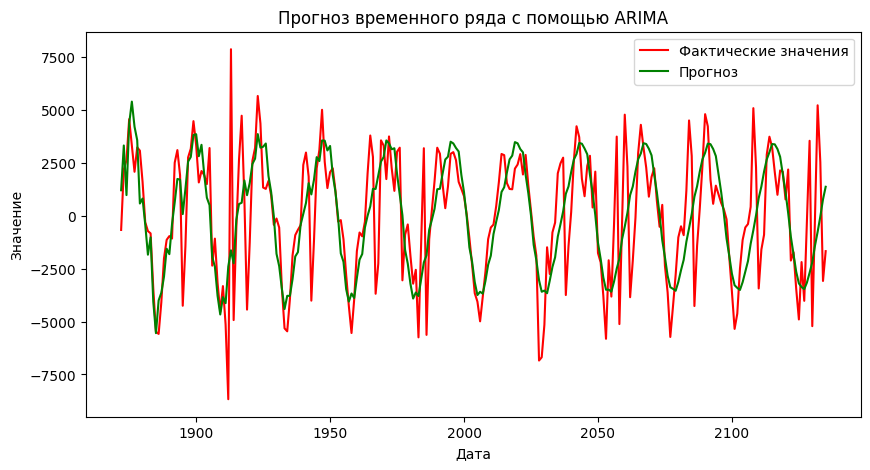

MAE: 1541.3970609847665


In [ ]:
#1 запуск

model_1 = ARIMA(train_series_1, order=(34, 0, 31))
model_fit_1 = model_1.fit()

forecast_1 = model_fit_1.forecast(steps=len(test_series_1))

# Визуализация прогнозов и фактических значений тестовой выборки
plt.figure(figsize=(10, 5))
plt.plot(test_series_1.index, test_series_1.values, label='Фактические значения', color='red')
plt.plot(test_series_1.index, forecast_1.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae_1 = mean_absolute_error(test_series_1, forecast_1)
print(f'MAE: {mae_1}')

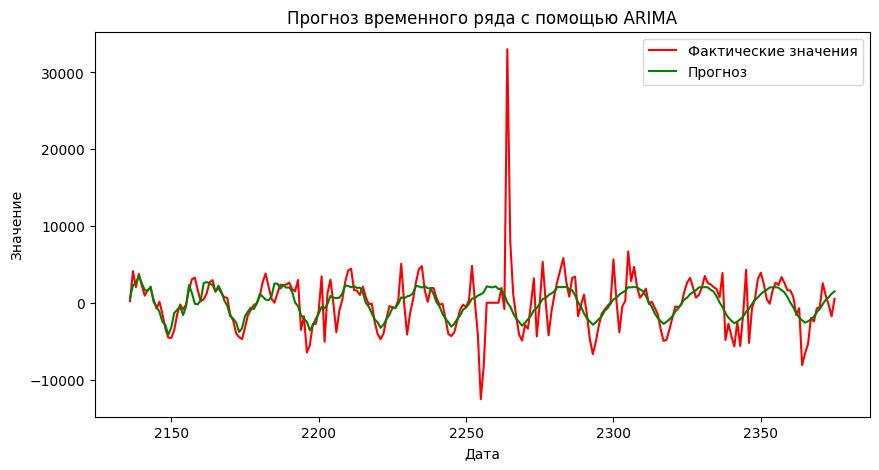

MAE: 1622.8529927533161


In [ ]:
#2 запуск

model_2 = ARIMA(train_series_2, order=(34, 0, 31))
model_fit_2 = model_2.fit()

forecast_2 = model_fit_2.forecast(steps=len(test_series_2))

plt.figure(figsize=(10, 5))
plt.plot(test_series_2.index, test_series_2.values, label='Фактические значения', color='red')
plt.plot(test_series_2.index, forecast_2.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae_2 = mean_absolute_error(test_series_2, forecast_2)
print(f'MAE: {mae_2}')

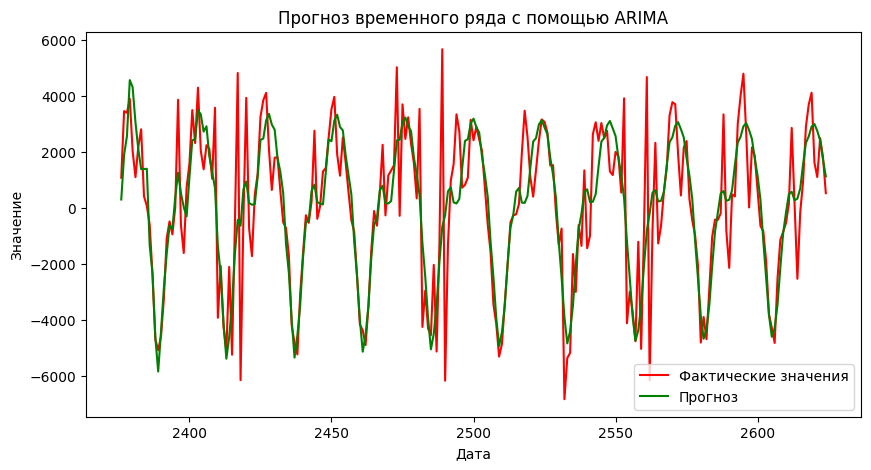

MAE: 1040.9879010389013


In [ ]:
#3 запуск

model_3 = ARIMA(train_series_3, order=(34, 0, 31))
model_fit_3 = model_3.fit()

forecast_3 = model_fit_3.forecast(steps=len(test_series_3))

# Визуализация прогнозов и фактических значений тестовой выборки
plt.figure(figsize=(10, 5))
plt.plot(test_series_3.index, test_series_3.values, label='Фактические значения', color='red')
plt.plot(test_series_3.index, forecast_3.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae_3 = mean_absolute_error(test_series_3, forecast_3)
print(f'MAE: {mae_3}')

**Можно увидеть, что из за выбросов(шума) ошибка была выше при втором запуске**

In [ ]:
#Вариатн 2

index_train_main = df[df['Time'] == '3/20/17 0:00'].index[0] #80
index_test_first_10 = df[df['Time'] == '3/31/17 0:00'].index[0] # 10
train_series_1 = diff_series[:index_train_main]
test_series_1 = diff_series[index_train_main:index_test_first_10]

first_10 = df[df['Time'] == '1/11/17 0:00'].index[0] #индекс первого 10 дней
index_test_second_10 = df[df['Time'] == '4/10/17 0:00'].index[0] # вторая 10 для теста
train_series_2 = diff_series[first_10:index_test_first_10]  #обучающая, где первые 10 отбрасыаются и дополняются тестовой 10
test_series_2 = diff_series[index_test_first_10:index_test_second_10] #10

first_20 = df[df['Time'] == '1/21/17 0:00'].index[0] #индекс вторых 10 дней
train_series_3 = diff_series[first_20:index_test_second_10]  #обучающая, где первые 20 отбрасыаются и дополняются тестовой 10
test_series_3 = diff_series[index_test_second_10:] #10

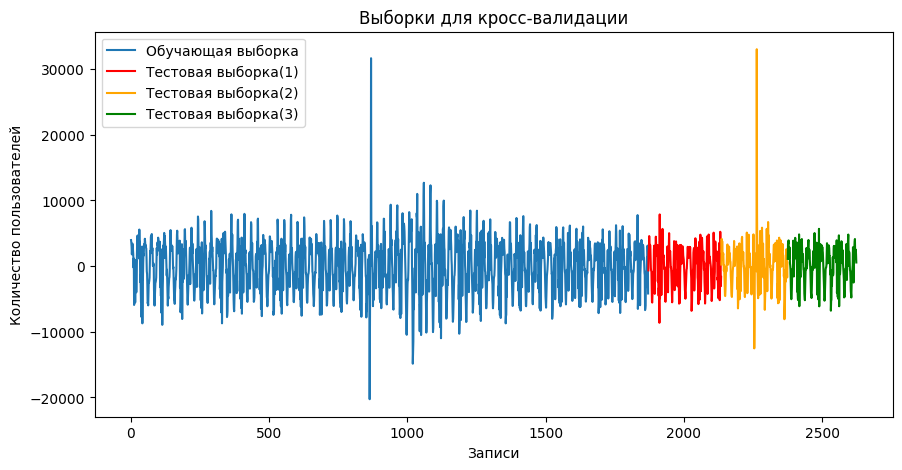

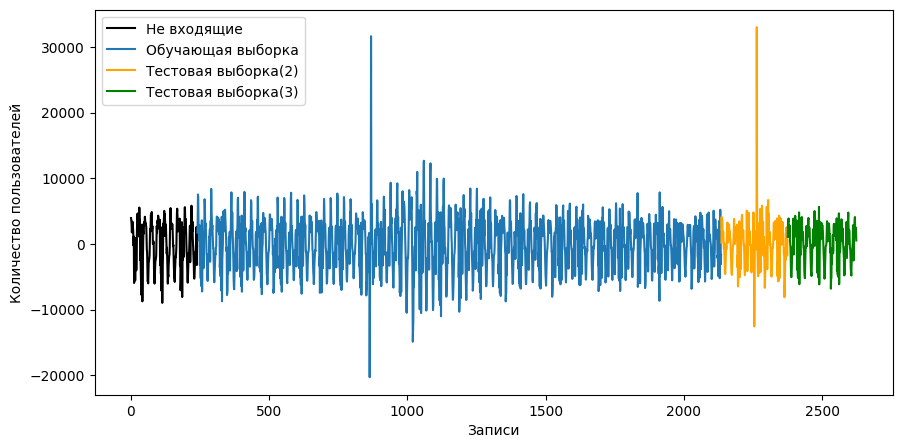

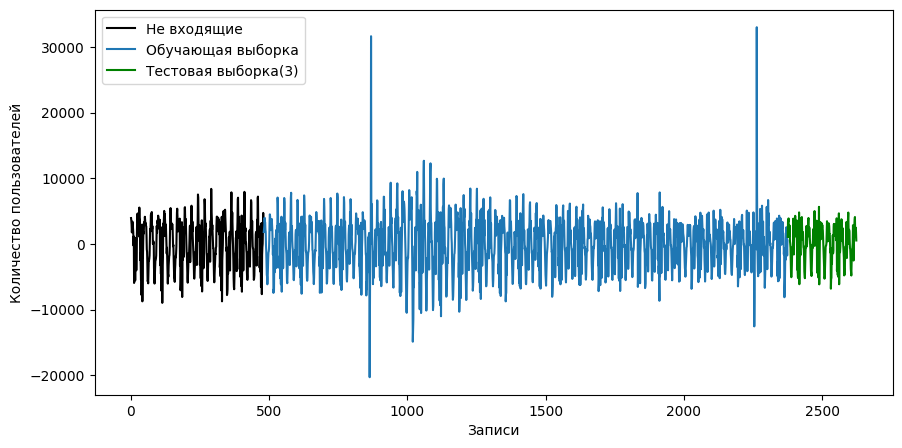

In [ ]:
plt.figure(figsize=(35, 5))
plt.subplot(1,3,1)
plt.plot(train_series_1, label='Обучающая выборка')
plt.plot(test_series_1, label='Тестовая выборка(1)', color='red')
plt.plot(test_series_2, label='Тестовая выборка(2)', color='orange')
plt.plot(test_series_3, label='Тестовая выборка(3)', color='green')
plt.title('Выборки для кросс-валидации')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

plt.figure(figsize=(35, 5))
plt.subplot(1,3,2)
plt.plot(diff_series[:first_10], label='Не входящие', color='black')
plt.plot(train_series_2, label='Обучающая выборка')
plt.plot(test_series_2, label='Тестовая выборка(2)', color='orange')
plt.plot(test_series_3, label='Тестовая выборка(3)', color='green')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

plt.figure(figsize=(35, 5))
plt.subplot(1,3,3)
plt.plot(diff_series[:first_20], label='Не входящие', color='black')
plt.plot(train_series_3, label='Обучающая выборка')
plt.plot(test_series_3, label='Тестовая выборка(3)', color='green')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

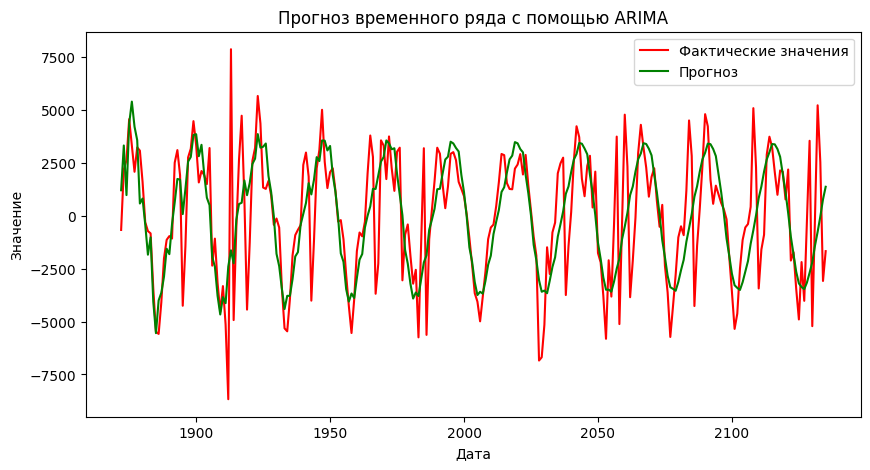

MAE: 1541.3970609847665


In [ ]:
#1 запуск

model_1 = ARIMA(train_series_1, order=(34, 0, 31))
model_fit_1 = model_1.fit()

forecast_1 = model_fit_1.forecast(steps=len(test_series_1))

# Визуализация прогнозов и фактических значений тестовой выборки
plt.figure(figsize=(10, 5))
plt.plot(test_series_1.index, test_series_1.values, label='Фактические значения', color='red')
plt.plot(test_series_1.index, forecast_1.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae_1 = mean_absolute_error(test_series_1, forecast_1)
print(f'MAE: {mae_1}')

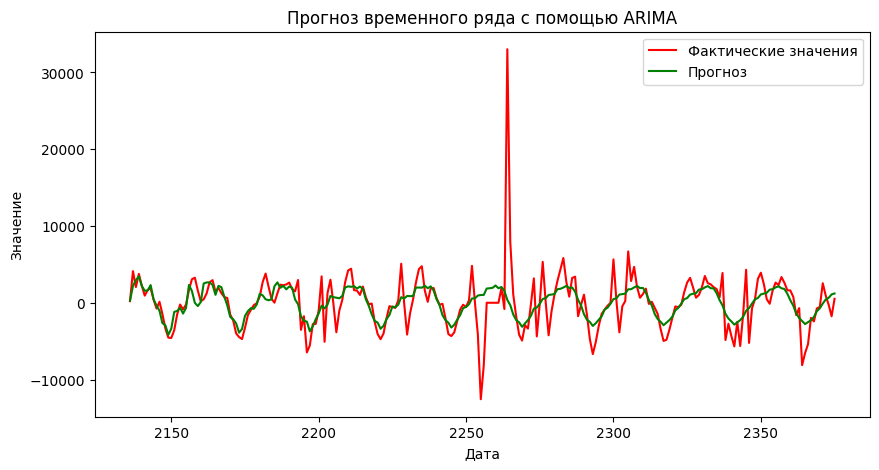

MAE: 1573.4064823771687


In [ ]:
#2 запуск

model_2 = ARIMA(train_series_2, order=(34, 0, 31))
model_fit_2 = model_2.fit()

forecast_2 = model_fit_2.forecast(steps=len(test_series_2))

# Визуализация прогнозов и фактических значений тестовой выборки
plt.figure(figsize=(10, 5))
plt.plot(test_series_2.index, test_series_2.values, label='Фактические значения', color='red')
plt.plot(test_series_2.index, forecast_2.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae_2 = mean_absolute_error(test_series_2, forecast_2)
print(f'MAE: {mae_2}')

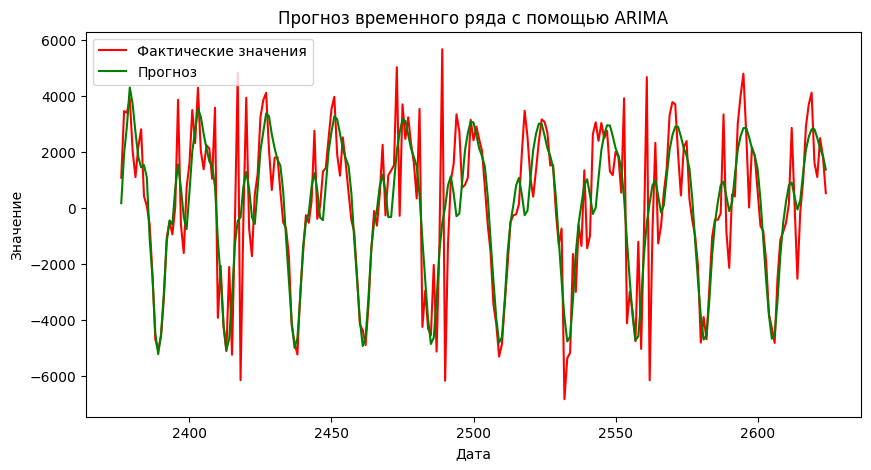

MAE: 1060.6390205983116


In [ ]:
#3 запуск

model_3 = ARIMA(train_series_3, order=(34, 0, 31))
model_fit_3 = model_3.fit()

forecast_3 = model_fit_3.forecast(steps=len(test_series_3))

plt.figure(figsize=(10, 5))
plt.plot(test_series_3.index, test_series_3.values, label='Фактические значения', color='red')
plt.plot(test_series_3.index, forecast_3.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae_3 = mean_absolute_error(test_series_3, forecast_3)
print(f'MAE: {mae_3}')

**Исходя из графиков видно, что во втором варианте при 2-ом запуске ошибка увеличилась, но не так, как в 1-ом варианте. Немного увеличилось значение ошибки при 3-ем запуске, чем в 1-ом варианте**

# Иследование параметров p, d, q в модели ARIMA

p -> указывает, сколько прошлых значений включать в модель.

d -> обозначает порядок дифференцирования. Он указывает, сколько раз необходимо дифференцировать временной ряд, чтобы сделать его стационарным.

q -> обозначает порядок модели скользящего среднего. Он указывает, сколько прошлых ошибок (остатков) включать в модель.

Иследовать будем на изночальном ряде, так как нам надо также понять, как влияет параметр d


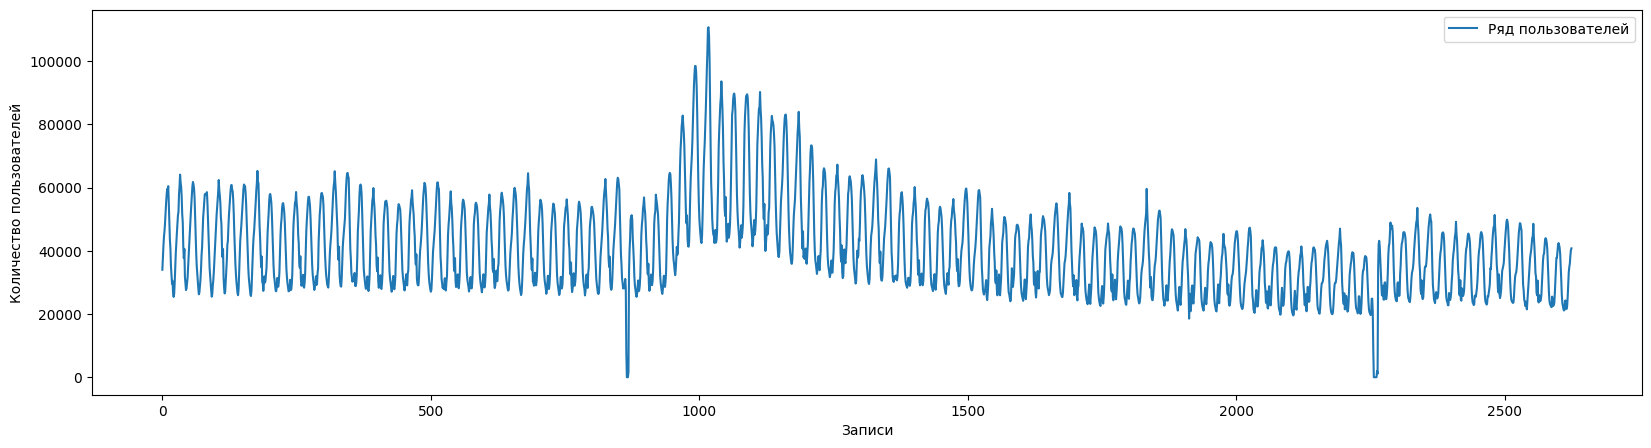

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df['Users'], label='Ряд пользователей')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

In [ ]:
index_train = df[df['Time'] == '4/10/17 0:00'].index[0]

train_series = df['Users'][:index_train]
test_series = df['Users'][index_train:]

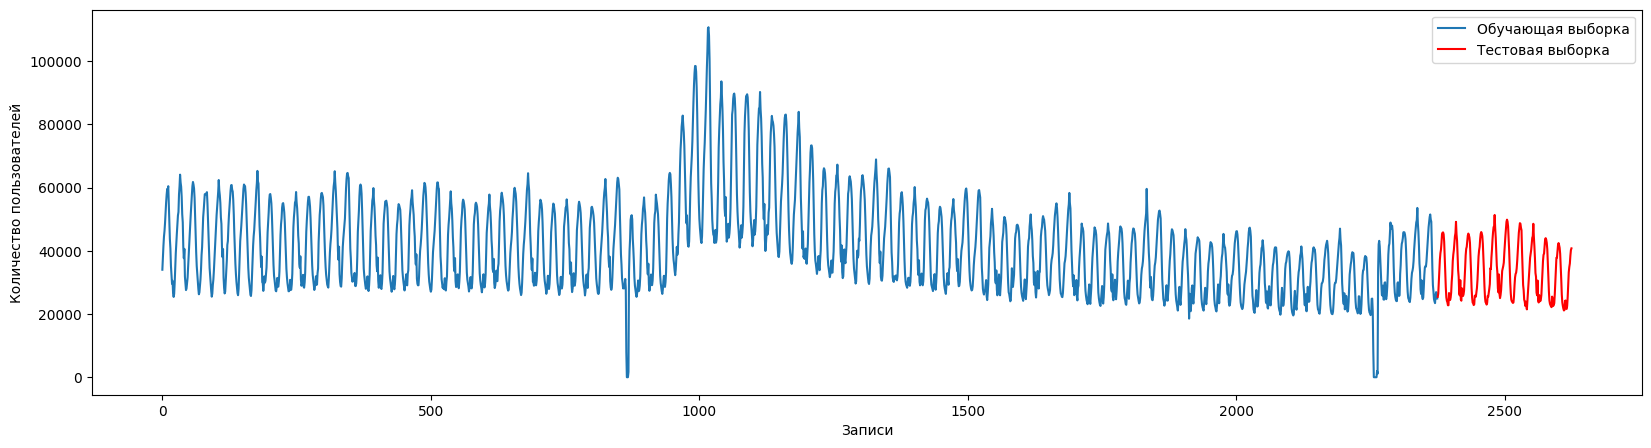

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(train_series, label='Обучающая выборка')
plt.plot(test_series, label='Тестовая выборка', color='red')
plt.xlabel('Записи')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

**Поставим все параметры по 10(кроме d) и потом будем изменять каждый параметр**

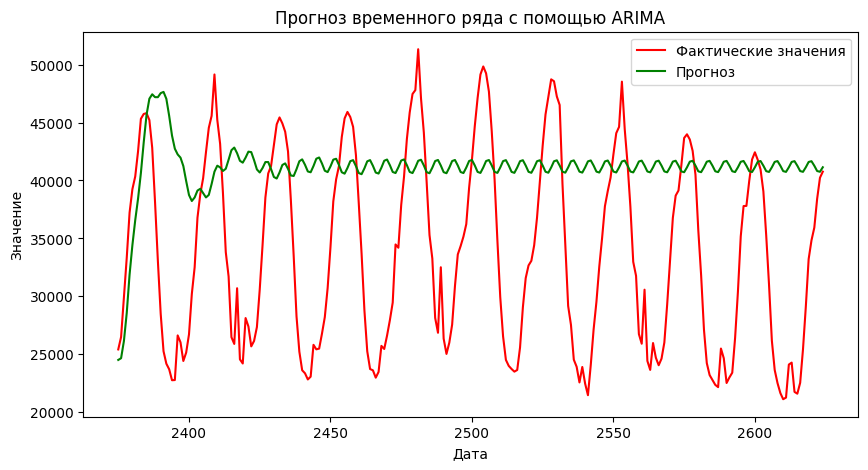

MAE: 9501.009939637388


In [ ]:
model = ARIMA(train_series, order=(10, 0, 10))
model_fit = model.fit()

# Прогнозирование на тестовой выборке
forecast = model_fit.forecast(steps=len(test_series))

plt.figure(figsize=(10, 5))
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='Прогноз', color='green')
plt.title('Прогноз временного ряда с помощью ARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae = mean_absolute_error(test_series, forecast)
print(f'MAE: {mae}')

Будем изменять p:

In [ ]:
model_p_2 = ARIMA(train_series, order=(2, 0, 10))
model_p_5 = ARIMA(train_series, order=(5, 0, 10))
model_p_12 = ARIMA(train_series, order=(12, 0, 10))
model_p_15 = ARIMA(train_series, order=(15, 0, 10))
model_p_20 = ARIMA(train_series, order=(20, 0, 10))

model_fit_2 = model_p_2.fit()
model_fit_5 = model_p_5.fit()
model_fit_12 = model_p_12.fit()
model_fit_15 = model_p_15.fit()
model_fit_20 = model_p_20.fit()

forecast_2 = model_fit_2.forecast(steps=len(test_series))
forecast_5 = model_fit_5.forecast(steps=len(test_series))
forecast_12 = model_fit_12.forecast(steps=len(test_series))
forecast_15 = model_fit_15.forecast(steps=len(test_series))
forecast_20 = model_fit_20.forecast(steps=len(test_series))


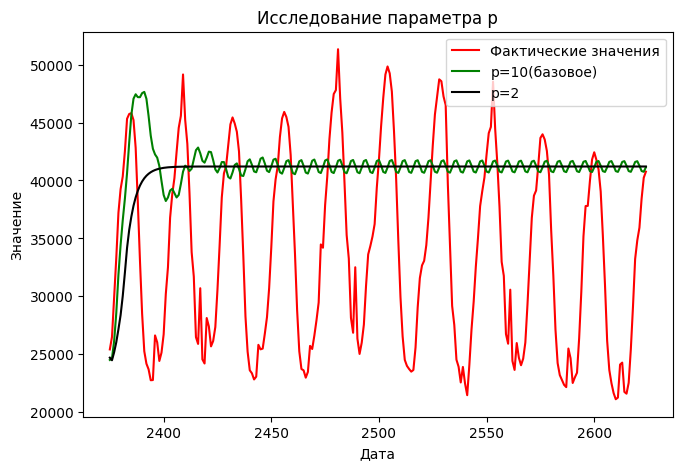

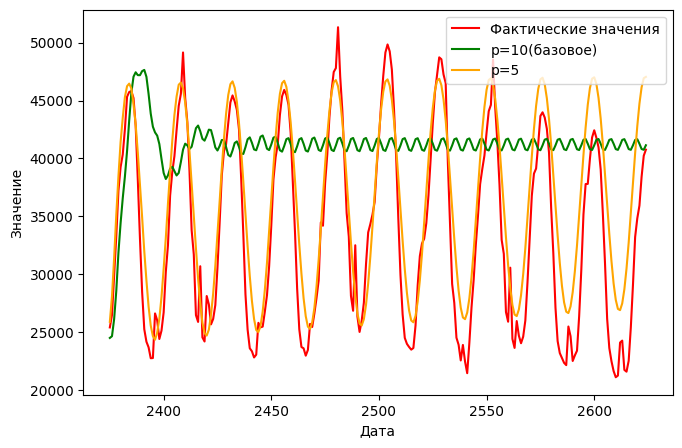

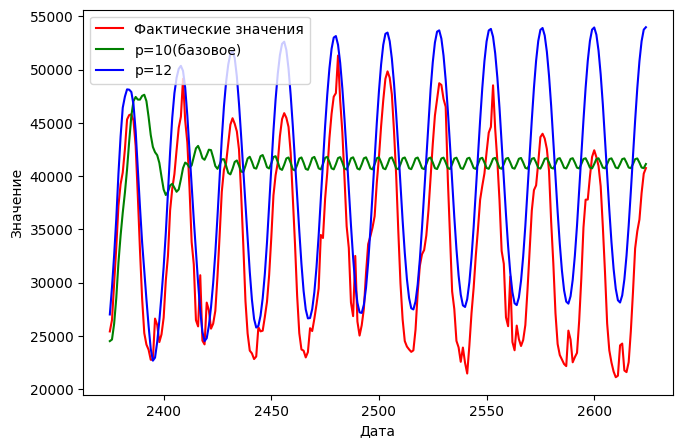

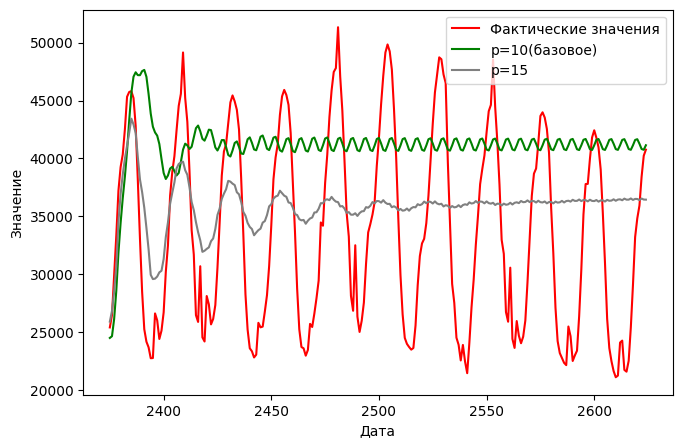

In [ ]:
plt.figure(figsize=(35, 5))
plt.subplot(1,4,1)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='p=10(базовое)', color='green')
plt.plot(test_series.index, forecast_2.values, label='p=2', color='black')
plt.title('Исследование параметра p')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()


plt.figure(figsize=(35, 5))
plt.subplot(1,4,2)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='p=10(базовое)', color='green')
plt.plot(test_series.index, forecast_5.values, label='p=5', color='orange')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

plt.figure(figsize=(35, 5))
plt.subplot(1,4,3)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='p=10(базовое)', color='green')
plt.plot(test_series.index, forecast_12.values, label='p=12', color='blue')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

plt.figure(figsize=(35, 5))
plt.subplot(1,4,4)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='p=10(базовое)', color='green')
plt.plot(test_series.index, forecast_15.values, label='p=15', color='gray')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

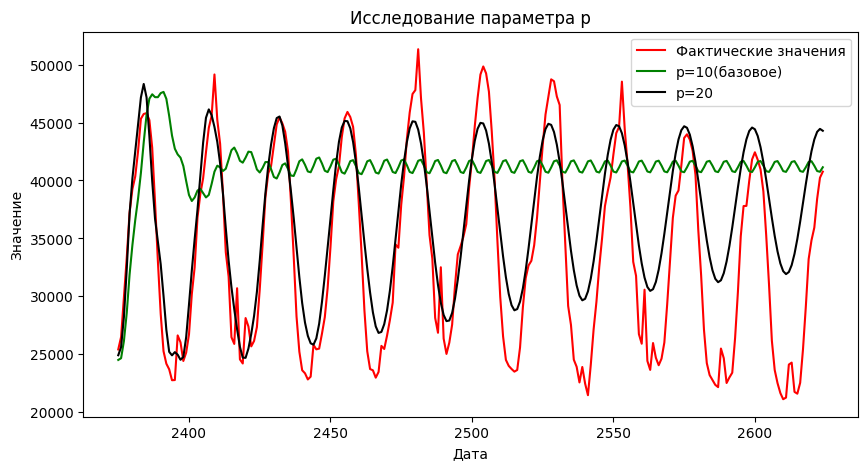

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='p=10(базовое)', color='green')
plt.plot(test_series.index, forecast_20.values, label='p=20', color='black')
plt.title('Исследование параметра p')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
mae_2 = mean_absolute_error(test_series, forecast_2)
mae_5 = mean_absolute_error(test_series, forecast_5)
mae_12 = mean_absolute_error(test_series, forecast_12)
mae_15 = mean_absolute_error(test_series, forecast_15)
mae_20 = mean_absolute_error(test_series, forecast_20)
print(f'MAE:\np=2 -> {mae_2}\np=5 -> {mae_5}\np=12 -> {mae_12}\np=15 -> {mae_15}\n {mae_20}')

MAE:
p=2 -> 9505.722782129218
p=5 -> 3358.1500227248007
p=12 -> 6301.137661246989
p=15 -> 6850.513898188568
 3856.6530220895306


**При увеличении прогнозы стали больше попадать в пики(как в верху, так и в нижних точках), но вот со значением 15 произошла какая-то непонятность, а вот с 20 уже лучше(резульат на таком же уровне, что и со значением 5)**

Будем изменять d:

In [ ]:
model_d_1 = ARIMA(train_series, order=(10, 1, 10))
model_d_2 = ARIMA(train_series, order=(10, 2, 10))
model_d_3 = ARIMA(train_series, order=(10, 3, 10))

model_fit_1 = model_d_1.fit()
model_fit_2 = model_d_2.fit()
model_fit_3 = model_d_3.fit()

forecast_1 = model_fit_1.forecast(steps=len(test_series))
forecast_2 = model_fit_2.forecast(steps=len(test_series))
forecast_3 = model_fit_3.forecast(steps=len(test_series))

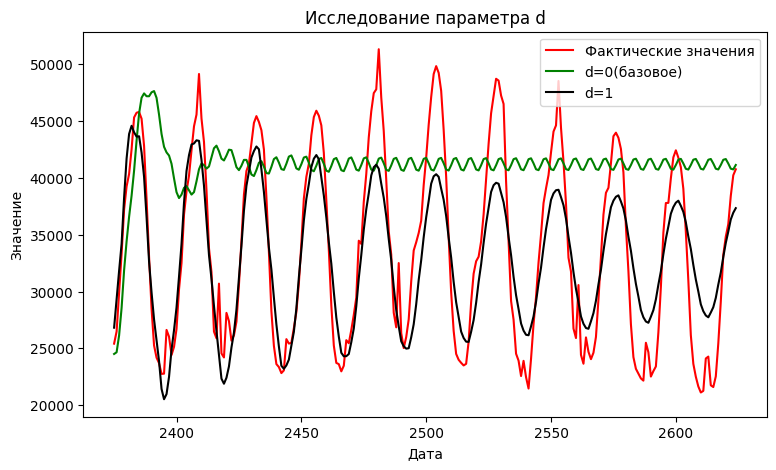

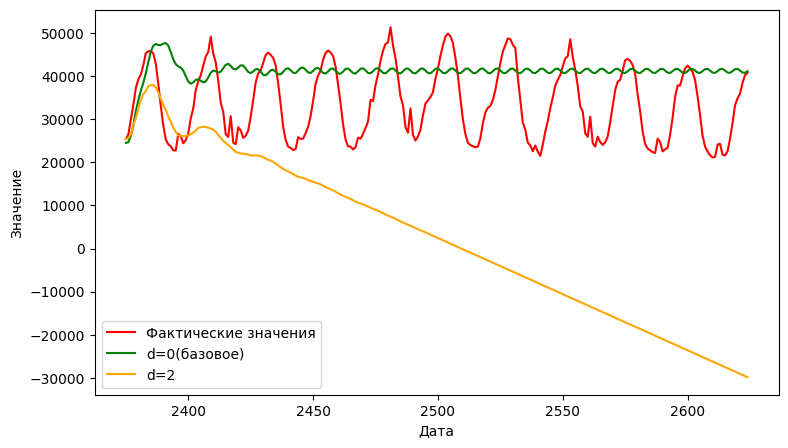

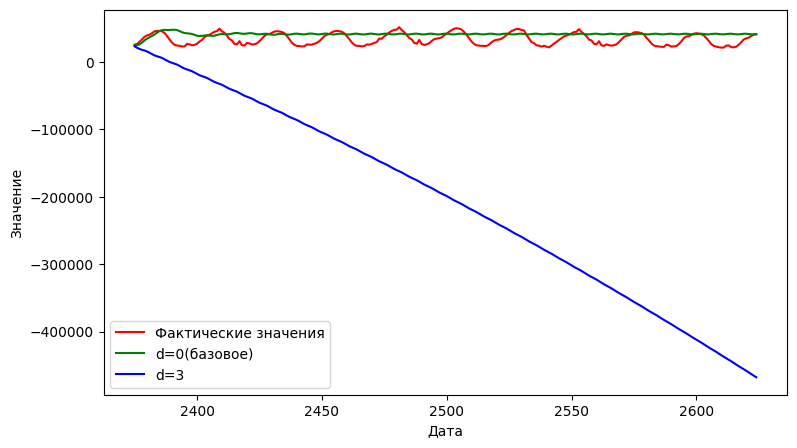

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(1,3,1)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='d=0(базовое)', color='green')
plt.plot(test_series.index, forecast_1.values, label='d=1', color='black')
plt.title('Исследование параметра d')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()


plt.figure(figsize=(30, 5))
plt.subplot(1,3,2)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='d=0(базовое)', color='green')
plt.plot(test_series.index, forecast_2.values, label='d=2', color='orange')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

plt.figure(figsize=(30, 5))
plt.subplot(1,3,3)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='d=0(базовое)', color='green')
plt.plot(test_series.index, forecast_3.values, label='d=3', color='blue')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
mae_1 = mean_absolute_error(test_series, forecast_1)
mae_2 = mean_absolute_error(test_series, forecast_2)
mae_3 = mean_absolute_error(test_series, forecast_3)
print(f'MAE:\nd=1 -> {mae_1}\nd=2 -> {mae_2}\nd=3 -> {mae_3}')

MAE:
d=1 -> 3339.9448593212796
d=2 -> 31390.201350114094
d=3 -> 239942.8533089236


**На значении 1, модель адаптировала ряд, но с увеличение d стало видно, что модель уже сглаживает ряд**

Будем изменять q:

In [ ]:
model_q_2 = ARIMA(train_series, order=(10, 0, 2))
model_q_5 = ARIMA(train_series, order=(10, 0, 5))
model_q_12 = ARIMA(train_series, order=(10, 0, 12))
model_q_15 = ARIMA(train_series, order=(10, 0, 15))
model_q_20 = ARIMA(train_series, order=(10, 0, 20))

model_fit_2 = model_q_2.fit()
model_fit_5 = model_q_5.fit()
model_fit_12 = model_q_12.fit()
model_fit_15 = model_q_15.fit()
model_fit_20 = model_q_20.fit()

forecast_2 = model_fit_2.forecast(steps=len(test_series))
forecast_5 = model_fit_5.forecast(steps=len(test_series))
forecast_12 = model_fit_12.forecast(steps=len(test_series))
forecast_15 = model_fit_15.forecast(steps=len(test_series))
forecast_20 = model_fit_20.forecast(steps=len(test_series))


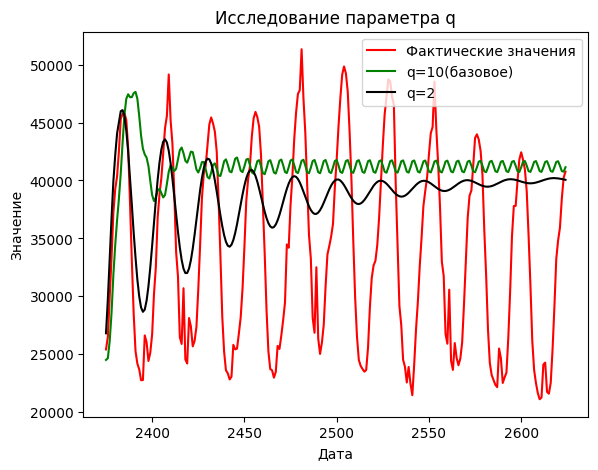

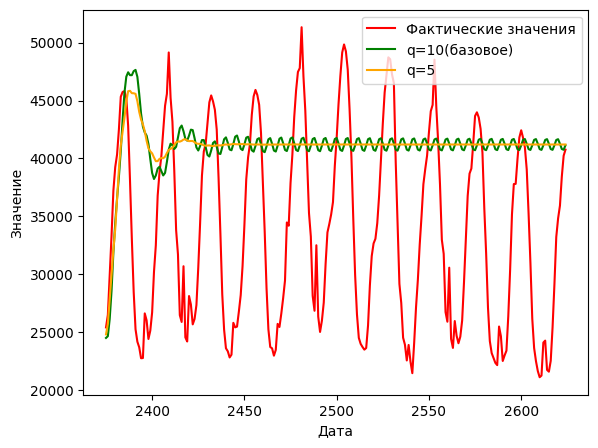

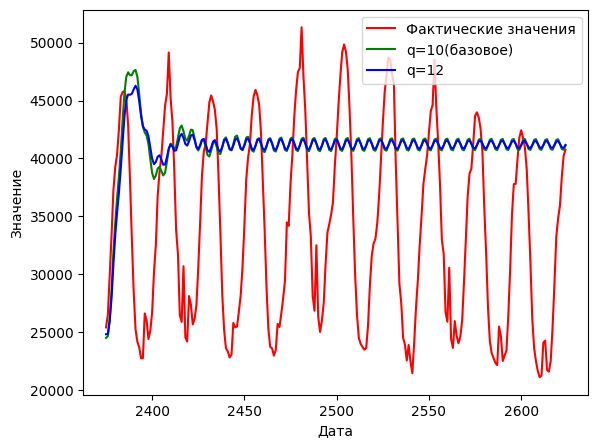

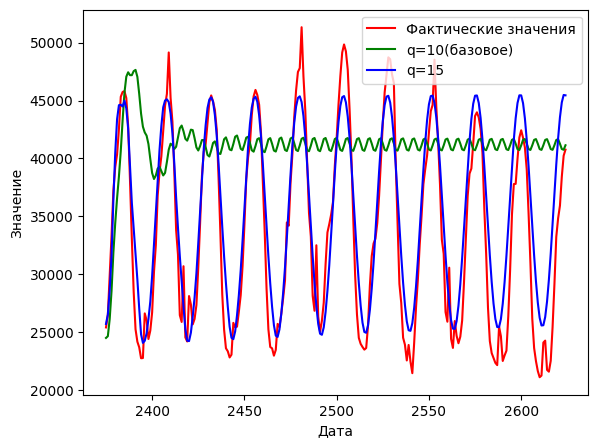

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(1,4,1)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='q=10(базовое)', color='green')
plt.plot(test_series.index, forecast_2.values, label='q=2', color='black')
plt.title('Исследование параметра q')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()


plt.figure(figsize=(30, 5))
plt.subplot(1,4,2)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='q=10(базовое)', color='green')
plt.plot(test_series.index, forecast_5.values, label='q=5', color='orange')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

plt.figure(figsize=(30, 5))
plt.subplot(1,4,3)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='q=10(базовое)', color='green')
plt.plot(test_series.index, forecast_12.values, label='q=12', color='blue')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

plt.figure(figsize=(30, 5))
plt.subplot(1,4,4)
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='q=10(базовое)', color='green')
plt.plot(test_series.index, forecast_15.values, label='q=15', color='blue')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

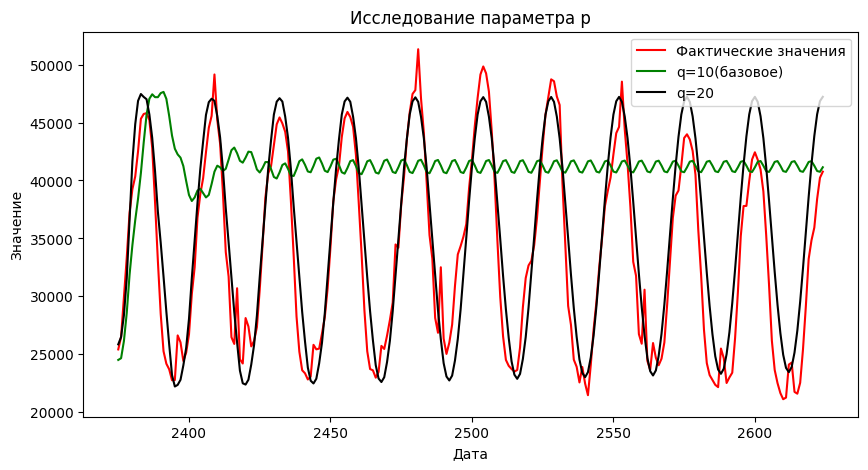

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast.values, label='q=10(базовое)', color='green')
plt.plot(test_series.index, forecast_20.values, label='q=20', color='black')
plt.title('Исследование параметра p')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
mae_2 = mean_absolute_error(test_series, forecast_2)
mae_5 = mean_absolute_error(test_series, forecast_5)
mae_12 = mean_absolute_error(test_series, forecast_12)
mae_15 = mean_absolute_error(test_series, forecast_15)
mae_20 = mean_absolute_error(test_series, forecast_20)
print(f'MAE:\np=2 -> {mae_2}\np=5 -> {mae_5}\np=12 -> {mae_12}\np=15 -> {mae_15},\n {mae_20}')

MAE:
p=2 -> 7320.420356500828
p=5 -> 9422.608243398998
p=12 -> 9488.402626065135
p=15 -> 2749.516353401872,
 2805.3321512205803


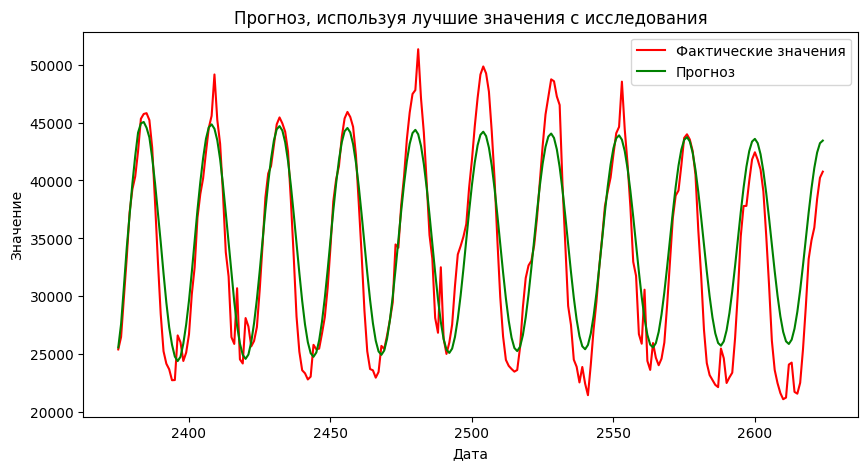

MAE: 2657.6252085905317


In [ ]:
model_best = ARIMA(train_series, order=(5, 1, 15))
model_fit = model_best.fit()

forecast_best = model_fit.forecast(steps=len(test_series))

plt.figure(figsize=(10, 5))
plt.plot(test_series, label='Фактические значения', color='red')
plt.plot(test_series.index, forecast_best.values, label='Прогноз', color='green')
plt.title('Прогноз, используя лучшие значения с исследования')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

mae = mean_absolute_error(test_series, forecast_best)
print(f'MAE: {mae}')